# [RNN(Recurrent Neural Networks)](https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D)

## Vanilla RNN
- $h_t$: 은닉층
- $y_t$: 출력층
- $X_t$: 입력층
- $tanh()$: 비선형 활성화 함수

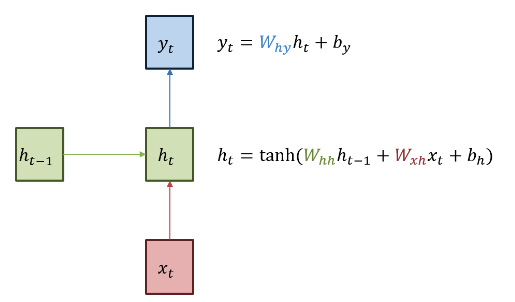

### [Vanilla RNN 단점](https://needjarvis.tistory.com/684)

- 일반적인 RNN의 경우 짧은 시퀀스를 처리할 경우 유리하며, 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀어지는 경우 학습 능력이 현저하게 저하된다.

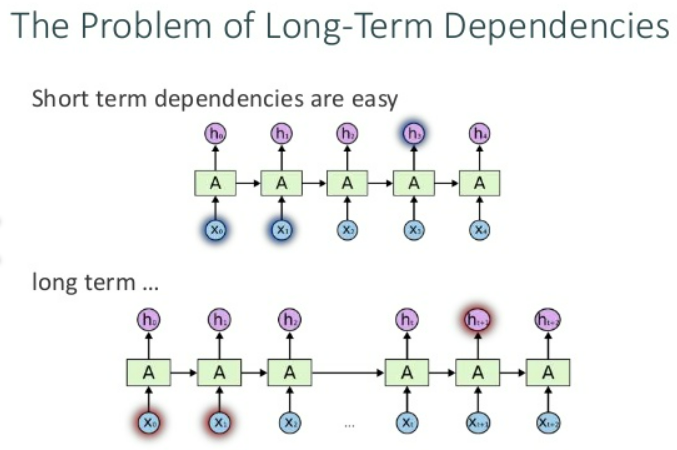

## [LSTM(Long Short Term Memory)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   
> Vanilla RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있습니다. 이를 `vanishing gradient problem`이라고 합니다.    
  
이 문제를 극복하기 위해서 고안된 것이 바로 LSTM입니다.

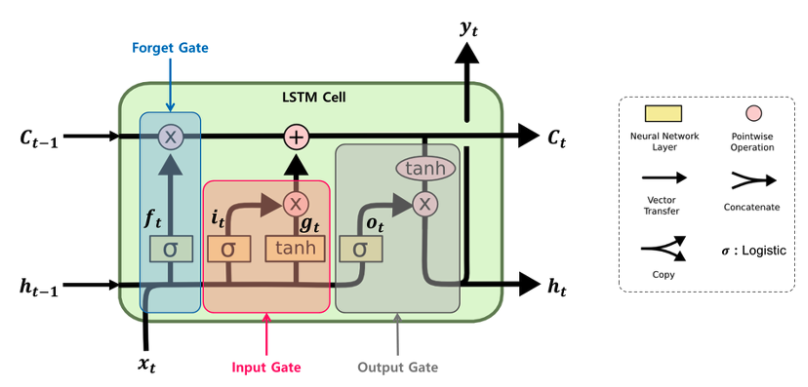

### LSTM 구조 설명
LSTM의 핵심은 cell state인데, 모듈 그림에서 수평으로 그어진 윗 선에 해당한다.  
Cell state는 컨베이어 벨트와 같아서, 작은 linear interaction만을 적용히키면서 전체 체인을 계속 구동시킨다.  
  
Cell state에 뭔가를 더하거나 없앨 수 있는데, 이 방법을 Gate라고 한다.

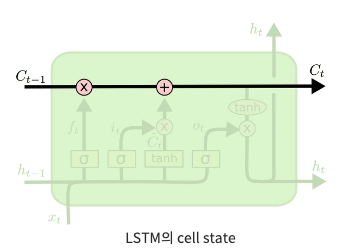

아래 그림은 sigmoid layer(0과 1 사이의 숫자를 내보냄)와 pointwise 곱셈을 나타낸 것이다.

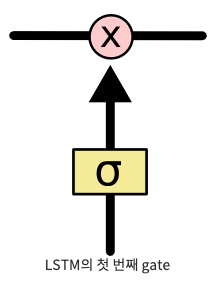

- Forget Gate   
과거 정보를 얼마나 잊을지에 대한 단계이다. 결과 값이 1이면 "이전 상태의 모든 정보를 보존"가 되고, 0이면 "이전 상태의 모든 정보를 삭제"가 된다.

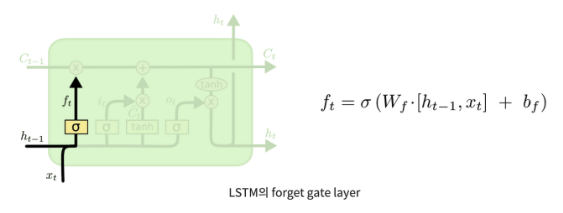

- Input Gate  
현재 정보를 얼마나 기억할 것인지에 대한 단계이다.

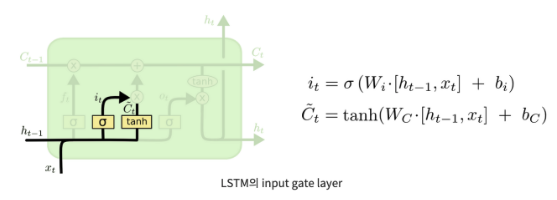

- State Update  
이전 cell state인 C(t-1)를 업데이트해서 새로운 cell state인 C(t)를 만드는 단계이다.

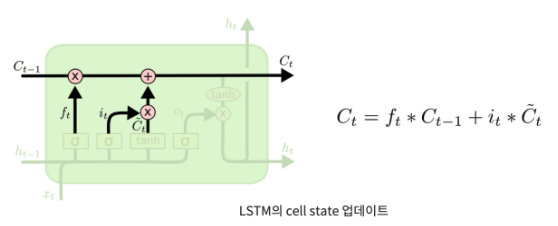

- Output Gate   
다음 state로 내보낼 output(hidden state)을 구하는 단계이다.

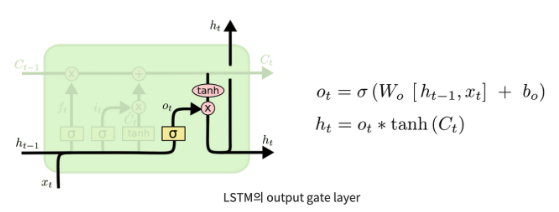

## Bi-LSTM(Bi-directional long short term memory)
- RNN이나 LSTM은 입력 순서를 시간 순대로 입력하기 때문에 결과물이 직전 패턴을 기반으로 수렴하는 경향을 보인다는 한계가 있습니다.
- 이 단점을 해결하는 목적으로 양방향 순환신경망(Bi-LSTM)이 제안되었습니다.

예를 들어 "나는 영화를 보았습니다."에서     
- RNN/LSTM인 경우, "나는"을 이용해서 "영화를" 예측해야 합니다.    
(즉, 예측이 힘듭니다.)  
- Bi-LSTM인 경우, "나는", "보았습니다."를 이용해서 "영화를" 예측하는 구조입니다.

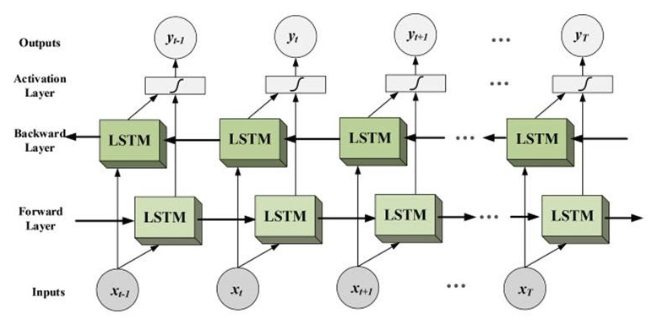

# [Simple LSTM](https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/3-2.TextLSTM/TextLSTM.ipynb)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
n_step = 3 # number of cells(= number of Step) # 재귀가 3번 이라는 의미
n_hidden = 128 # number of hidden units in one cell

## Data

### 데이터 생성

In [3]:
seq_data = ['make', 'need', 'coal', 'word', 'love', 'hate', 'live', 'home', 'hash', 'star'] # 3개의 char를 이용해 마지막 값을 예측하는것
# 'm',a''k'를 학습해서 e를 유추하는것
seq_data

['make',
 'need',
 'coal',
 'word',
 'love',
 'hate',
 'live',
 'home',
 'hash',
 'star']

### 토큰화

In [4]:
char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz'] # 유연하게 짜야함 / 토큰화:char를 유니크하게 만듬..
len(char_arr) # 토큰데이터를 받음

26

### 사전생성

In [5]:
char_dict = {n: i for i, n in enumerate(char_arr)}
number_dict = {i: w for i, w in enumerate(char_arr)}
n_class = len(char_dict)  # number of class(=number of vocab) # a:1, b:2,c:3 이런식의 사전을 만듬
n_class

26

## Dataset

### 디버깅

In [6]:
seq = seq_data[0]
seq

'make'

In [7]:
seq[:-1] # features

'mak'

In [8]:
input = [char_dict[n] for n in seq[:-1]]
input # (m, a, k) -> (12, 0, 10)

[12, 0, 10]

In [9]:
[number_dict[n] for n in input]

['m', 'a', 'k']

In [10]:
seq[-1] # target

'e'

In [11]:
target = char_dict[seq[-1]]
target, number_dict[target]

(4, 'e')

In [12]:
np.eye(n_class)[input] # 원핫인코딩 (embedding)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:

# ## Dataset
# 1. 강사의 코드를 이해
# 2. dataset 클래스를 만들어서 적용(class를 만들수 있는 능력)
# 3. 원핫인코딩 대신 emdedding 적용(모델 클래스를 수정할 수 있는 능력이 있어야 가능)
# 4. 형태소 분석에서 사용한 데이터를 적용 (테스트 전처리)

In [14]:
seq_data = ['make', 'need', 'coal', 'word', 'love', 'hate', 'live', 'home', 'hash', 'star']

In [15]:
char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz']
char_arr

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [16]:
number_dict= {i:w for i,w in enumerate(char_arr)} # 숫자를 영어로
number_dict[0]

'a'

In [17]:
word_dict= {w:i for i,w in enumerate(char_arr)} # 영어를 숫자로
word_dict['a']

0

In [18]:
for sen in seq_data:
      # 단어 추출한것에서 마지막 char 빼고
      feature=[word_dict[i] for i in sen[:-1]]
      target=word_dict[sen[-1]]

In [19]:
feature

[18, 19, 0]

In [20]:
target

17

In [21]:
# Ver1
from torch.utils.data.distributed import Dataset
import torch
class MakeDataset(Dataset):
  # 모델 정의
  # 사전 작업
  def __init__(self,sentence):
    super().__init__()
  # 0-1. 토큰화 받아서 토큰화 하기
    self.char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz'] # 토큰화 하기
  # 0-2. 토큰화된거 사전집 만들기
    self.n_class = len(char_arr) # 길이 갖고옴
    self.number_dict= {i:w for i,w in enumerate(char_arr)} # 숫자를 영어로
    self.word_dict= {w:i for i,w in enumerate(char_arr)} # 영어를 숫자로

  # 0-4. 숫자 받은거 원핫인코딩으로 만들기
    self.one_hot=np.eye(self.n_class)
  # 0-5. feature,target 정의
    self.features,self.targets= self.makedataset(sentence)
  #1. 기능 feature 만들기
  def makedataset(self,sentence):
    features=[]
    targets=[]
    # 리스트에서 단어 추출
    for sen in sentence:
      # 단어 추출한것에서 마지막 char 빼고 사전집으로 문자 받으면 숫자로 변경하기
      feature=[self.word_dict[i] for i in sen[:-1]]
      # 단어 추출에서 마지막것만 숫자로 변경하기
      target=self.word_dict[sen[-1]]
      #1-4. 숫자 받은거 원핫인코딩으로 임배딩하기
      features.append(self.one_hot[feature])
      targets.append(target)
    return torch.Tensor(features),torch.Tensor(targets) # torch로 변경하기!
  def __getitem__(self,idx):
    return self.features[idx],self.targets[idx]
  def __len__(self):
    return len(self.features)


In [22]:
da=MakeDataset(seq_data)

<ipython-input-21-2d244fa449d2>:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.Tensor(features),torch.Tensor(targets) # torch로 변경하기!


In [23]:
da.features.shape # input_size,데이터 3개 ,embeddingsize)

torch.Size([10, 3, 26])

In [27]:
da.features[0].shape

torch.Size([3, 26])

In [25]:
da.targets[0]

tensor(4.)

In [26]:
da.targets.shape # inputsize

torch.Size([10])

In [28]:
# ver2
from torch.utils.data.distributed import Dataset
import torch
class MakeDataset2(Dataset):
  # 모델 정의
  # 사전 작업
  def __init__(self,sentence):
    super().__init__()
  # 0-1. 토큰화 받아서 토큰화 하기
    self.char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz'] # 토큰화 하기
  # 0-2. 토큰화된거 사전집 만들기
    self.n_class = len(char_arr) # 길이 갖고옴
    self.number_dict= {i:w for i,w in enumerate(char_arr)} # 숫자를 영어로
    self.word_dict= {w:i for i,w in enumerate(char_arr)} # 영어를 숫자로

  # 0-4. 숫자 받은거 원핫인코딩으로 만들기
    self.one_hot=np.eye(self.n_class)
  # 0-5. feature,target 정의
    self.features,self.targets= self.makedataset(sentence)
  #1. 기능 feature 만들기
  def makedataset(self,sentence):
    features=[]
    targets=[]
    # 리스트에서 단어 추출
    for sen in sentence:
      # 단어 추출한것에서 마지막 char 빼고 사전집으로 문자 받으면 숫자로 변경하기
      feature=[self.word_dict[i] for i in sen[:-1]]
      # 단어 추출에서 마지막것만 숫자로 변경하기
      target=self.word_dict[sen[-1]]
      #1-4. 숫자 받은거 원핫인코딩으로 임배딩하기
      features.append(feature)
      targets.append(target)
    return torch.Tensor(features),torch.Tensor(targets) # torch로 변경하기!
  def __getitem__(self,idx):
    return self.features[idx],self.targets[idx]
  def __len__(self):
    return len(self.features)



In [29]:
da2=MakeDataset2(seq_data)

In [30]:
da2.features[0]

tensor([12.,  0., 10.])

In [31]:
da2.targets.shape

torch.Size([10])

In [32]:
da2.features.shape # # 10개의 데이터에서 ,3개 ->inputdata
da2[0][0] # 3개의 inputdata

tensor([12.,  0., 10.])

In [40]:
len(da2)

10

In [33]:
def make_batch():
    input_batch, target_batch = [], []

    for seq in seq_data:
        input = [char_dict[n] for n in seq[:-1]] # 'm', 'a' , 'k' is input
        target = char_dict[seq[-1]] # 'e' is target
        input_batch.append(np.eye(n_class)[input]) # 원핫인코딩(embedding)
        target_batch.append(target)

    return input_batch, target_batch

In [34]:
input_batch, target_batch = make_batch()
# input_batch => (batch_size, input_size, embedding_size)
np.array(input_batch).shape, np.array(target_batch).shape

((10, 3, 26), (10,))

## LSTM 모델 생성

In [35]:
class TextLSTM(nn.Module):
    def __init__(self,n_class, n_hidden=128): # forwaard를 위한 사전 작업
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden)
        self.linear = nn.Linear(n_hidden, n_class, bias=False)

    def forward(self, X): # X => (batch_size, input_size, embedding_size)
        input = X.transpose(0, 1)  # input : (input_size, batch_size, embedding_size)

        hidden_state = torch.zeros(1, len(X), n_hidden)  # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        cell_state = torch.zeros(1, len(X), n_hidden)     # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]

        # outputs: [input_size, batch_size, n_hidden]
        outputs, (hidden_state, cell_state) = self.lstm(input, (hidden_state, cell_state)) # cell_state는 사용하지 않음!!!
        _output = outputs[-1]  # _output: [batch_size, n_hidden] -> outputs 또는 hidden_state 아무거나 사용 가능!! 보통은 아웃풋보다 hidden을 많이씀
        pred = self.linear(_output) # pred : [batch_size, n_class]
        return pred

## 모델 학습

In [46]:
model = TextLSTM(len(da))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_batch, target_batch = make_batch()
input_batch = torch.FloatTensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [48]:
for epoch in range(1000):

    output = model(input_batch) # batch_size = 전체 데이터 크기
    loss = criterion(output, target_batch)
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

RuntimeError: ignored

## 모델 예측

In [43]:
pred = model(input_batch)
pred.shape

RuntimeError: ignored

In [ ]:
pred_soft = pred.softmax(dim=1)
pred_soft.shape

torch.Size([10, 26])

In [ ]:
pred_max = pred_soft.argmax(dim=1)
pred_max.shape

torch.Size([10])

In [ ]:
inputs = [sen[:3] for sen in seq_data]

print(inputs, '->', [number_dict[n.item()] for n in pred_max])

['mak', 'nee', 'coa', 'wor', 'lov', 'hat', 'liv', 'hom', 'has', 'sta'] -> ['e', 'd', 'l', 'd', 'e', 'e', 'e', 'e', 'h', 'r']


# [Load Data](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchtext.vocab import build_vocab_from_iterator

from tqdm.auto import tqdm

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


In [ ]:
df_en = pd.read_csv(DATA_PATH+"IMDB/IMDB-Dataset.csv")

print(f'{df_en.isnull().sum().sum()} / {df_en.shape}')
df_en.head()

0 / (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df_en = df_en[:5000]
print(f'{df_en.isnull().sum().sum()} / {df_en.shape}')
df_en.head()

0 / (5000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Text Preprocessing

## Cleaning(정제)

In [ ]:
df_en['sentiment'] = df_en['sentiment'].map({'positive':1, 'negative':0})

print(f'{df_en.isnull().sum().sum()} / {df_en.shape}')
df_en.head()

0 / (5000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
df_en['review'] = df_en['review'].map(lambda x: x.strip())
df_en['review'] = df_en['review'].map(lambda x: x.lower())

print(f'{df_en.isnull().sum().sum()} / {df_en.shape}')
df_en.head()

0 / (5000, 2)


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [ ]:
df_en['review'] = df_en['review'].map(lambda x: x.replace('<br />',''))

print(f'{df_en.isnull().sum().sum()} / {df_en.shape}')
df_en.head()

0 / (5000, 2)


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


## [Tokenization(토큰화)](https://spacy.io/models/en)

In [ ]:
import spacy # 형태소 분석기

In [ ]:
!python -m spacy download en_core_web_sm

2023-05-11 08:21:08.582342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
nlp = spacy.load("en_core_web_sm") # 형태소 분석기 객체 생성

In [ ]:
tmp = df_en['review'][0].split(' ')
tmp[:5]

['one', 'of', 'the', 'other', 'reviewers']

In [ ]:
doc = nlp(df_en['review'][0])
doc

one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me.the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.i would say the main appeal of the show is due to the fact that it goes where other shows wou

In [ ]:
print('-'*80)
print("단어","원형","품사","태그", "의존성", "모양", "알파벳", "금칙어",sep="\t")
for token in doc[:10]:
    print(
        token.text # 단어
        , token.lemma_ # 원형
        , token.pos_ # 품사
        , token.tag_ # 태그
        , token.dep_ # 의존성
        , token.shape_ # 모양
        , token.is_alpha # 알파벳
        , token.is_stop # 금칙어
        , sep='\t')

--------------------------------------------------------------------------------
단어	원형	품사	태그	의존성	모양	알파벳	금칙어
one	one	NUM	CD	nsubj	xxx	True	True
of	of	ADP	IN	prep	xx	True	True
the	the	DET	DT	det	xxx	True	True
other	other	ADJ	JJ	amod	xxxx	True	True
reviewers	reviewer	NOUN	NNS	pobj	xxxx	True	False
has	have	AUX	VBZ	aux	xxx	True	True
mentioned	mention	VERB	VBN	ROOT	xxxx	True	False
that	that	SCONJ	IN	mark	xxxx	True	True
after	after	ADP	IN	prep	xxxx	True	True
watching	watch	VERB	VBG	pcomp	xxxx	True	False


## Stemming(추출) / Stopword(불용어)

In [ ]:
def tokenizer(text):
    doc = nlp(text)
    return [ token.lemma_ for token in doc if token.tag_[0] in "NVJ"] # N(명사), V(동사), J(형용사)

In [ ]:
tmp = df_en['review'][0].split(' ')
tmp[:5]

['one', 'of', 'the', 'other', 'reviewers']

In [ ]:
tmp = tokenizer(df_en['review'][0])
tmp[:5]

['other', 'reviewer', 'have', 'mention', 'watch']

In [ ]:
def yield_tokens(data,tokenizer):
    for text in tqdm(data):
        yield tokenizer(text)

## 어휘집 생성
- `<pad>(패딩)`: 0
- `<unk>(정의되지 않은 문자)`: 1

In [ ]:
gen = yield_tokens(df_en["review"],tokenizer)
vocab = build_vocab_from_iterator(gen, specials=["<pad>","<unk>"])
vocab.set_default_index(vocab["<unk>"])
len(vocab)

  0%|          | 0/5000 [00:00<?, ?it/s]

35876

In [ ]:
vocab(["watching","other","reviewer"])

[5274, 19, 864]

In [ ]:
vocab.lookup_tokens([5274, 19, 864, 1, 0])

['watching', 'other', 'reviewer', '<unk>', '<pad>']

In [ ]:
features = [ vocab(tokenizer(text)) for text in df_en["review"].tolist()]
len(features)

5000

## Padding(패딩)

문장 최대길이

In [ ]:
max_len = max(len(lst) for lst in features)
max_len

913

패딩 적용

In [ ]:
features = [ lst + [0] * (max_len - len(lst))  if len(lst) < max_len else lst for lst in features]
features = np.array(features)
features.shape

(5000, 913)

In [ ]:
features[:2]

array([[ 19, 864,   3, ...,   0,   0,   0],
       [249,  43, 188, ...,   0,   0,   0]])

In [ ]:
max_len == len(features[:1][0])

True

# Dataset

In [ ]:
target = df_en["sentiment"].to_numpy()
target.shape

(5000,)

In [ ]:
target.reshape(-1,1).shape

(5000, 1)

In [ ]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self,x,y=None):
        self.x = x # features
        self.y = y.reshape(-1,1) # target

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        item = {}
        item["x"] = torch.LongTensor(self.x[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item

In [ ]:
dt = ReviewDataset(features,target)

In [ ]:
len(dt)

5000

# DataLoader

In [ ]:
dl = torch.utils.data.DataLoader(dt,batch_size=256,shuffle=True)

In [ ]:
len(dl) # 5000 / 256 -> 전체 데이터를 / 베치 크기

20

In [ ]:
batch = next(iter(dl))
batch['x'][:2], batch['y'][:2]

(tensor([[  49, 3422, 2109,  ...,    0,    0,    0],
         [   2,  100,   15,  ...,    0,    0,    0]]),
 tensor([[1.],
         [0.]]))

# LSTM

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
class LSTM_net(nn.Module):
  def __init__(self, size_vocab, device, num_output=1, dim_embed=64, hidden_size=64, linear_size=64, num_layers=1):
    super().__init__()
    self.device = device
    self.num_output = num_output
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.embed = nn.Embedding(size_vocab, dim_embed)
    # lstm: num_layers(lstm의 layer 수), bidirectional=True(Bi-LSTM)
    self.lstm = nn.LSTM(input_size=dim_embed, hidden_size=hidden_size,
                        num_layers=num_layers, dropout=0.3, bidirectional=True)
    self.fclayer = nn.Linear(hidden_size, linear_size)
    self.outlayer = nn.Linear(linear_size, num_output)


  def forward(self, x): # (batch, seq_len)
    scaler = 2 if self.lstm.bidirectional == True else 1 # Bi-LSTM(2), LSTM(1)

    emb = self.embed(x) # (batch, seq_len, dim_embed)

    # 초기화
    hidden_state = Variable(torch.zeros(self.num_layers*scaler, emb.size(0),
                                  self.hidden_size, requires_grad=True)).to(self.device)
    cell_state = Variable(torch.zeros(self.num_layers*scaler, emb.size(0),
                                  self.hidden_size, requires_grad=True)).to(self.device)

    out, (hidden_state, cell_state) = self.lstm(emb.transpose(1,0), (hidden_state, cell_state))
    h = hidden_state[-1] # 마지막 hidden 값만 사용

    h = self.fclayer(h).relu()
    predict = self.outlayer(h)
    return predict

In [ ]:
model = LSTM_net(len(vocab), device).to(device)
model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_net(
  (embed): Embedding(35876, 64)
  (lstm): LSTM(64, 64, dropout=0.3, bidirectional=True)
  (fclayer): Linear(in_features=64, out_features=64, bias=True)
  (outlayer): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
model(batch["x"]).shape

torch.Size([256, 1])

In [ ]:
batch["x"].shape

torch.Size([256, 913])

# Engine

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [ ]:
from sklearn.metrics import accuracy_score

@torch.inference_mode()
def test_loop(dataloader,model,loss_fn,device):
    epoch_loss = 0
    total_acc = 0
    model.eval()

    pred_list = []
    sig = torch.nn.Sigmoid()

    for batch in dataloader:

        pred = model(batch["x"].to(device))

        pred_ = sig(pred)
        pred_ = pred_.to("cpu").numpy()
        pred_list.append(pred_)

        if batch.get("y") is not None:
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()

            pred_ = (pred_ > 0.5).astype(int)
            total_acc += accuracy_score(batch["y"].to("cpu").numpy(), pred_)

    epoch_loss /= len(dataloader)
    total_acc /= len(dataloader)

    # epoch_pred = np.concatenate(pred_list)
    return epoch_loss , total_acc

# random_split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(features, target, test_size=0.1, shuffle=True)

In [ ]:
len(X_tr), len(y_tr), len(X_te), len(y_te)

(4500, 4500, 500, 500)

In [ ]:
X_tr[0], y_tr[0]

# KFold

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

SEED = 42
n_splits = 5
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

# Train

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
best_score_list = []
epochs = 100
batch_size = 256 #128
vocab_size = len(vocab)

loss_fn = torch.nn.BCEWithLogitsLoss()

for i,(tri,vai) in enumerate(cv.split(X_tr)):
    model = LSTM_net(len(vocab), device).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    train_dt = ReviewDataset(X_tr[tri],y_tr[tri])
    valid_dt = ReviewDataset(X_tr[vai],y_tr[vai])
    train_dl = DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    best_score = 0
    patience = 0

    for epoch in tqdm(range(epochs)):

        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device )
        valid_loss , score = test_loop(valid_dl, model, loss_fn, device  )

        patience += 1
        if best_score < score:
            print(f'best score: {train_loss, valid_loss, score}') # 트레인 로스, 벨리드 로스, 스코어
            patience = 0
            best_score = score
            # torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 20:
            break

    print(f"Fold ({i}), BEST ACC: {best_score}")
    best_score_list.append(best_score)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/100 [00:00<?, ?it/s]

# Test

In [ ]:
test_dt = ReviewDataset(X_te,y_te)
test_dl = DataLoader(test_dt, batch_size=batch_size,shuffle=False)

loss , pred = test_loop(test_dl, model, loss_fn, device  )

loss, pred